# Tutorial 2 - Melt

Welcome to the second tutorial of this series!
In this short notebook, we'll see how to join multiple measurements performed using different frame rates.
This will allow us to take advantage of the complementary features of both acquisitions, namely the higher resolution of the fast measurement at short lag times and the larger accuracy of the slow one on the long time plateau.

### Purpose

The goal of this tutorial is to demonstrate how to join multiple acquisitions using `melt` on two azimuthal averages.
Specifically, we will:

0. Set up the workspace and import the libraries
    1. Set up the workspace.
    2. Give an overview of the sample under investigation.
    3. Import libraries.
1. Compute the structure function of image sequences using DDM.
    1. Load the image sequences.
    2. Calculate the corresponding structure functions.
    3. Calculate the azimuthal averages.
2. Join (melt) the azimuthal averages.

The method outlined here could also be used to join more than two measurements, just by repeating the operations described below.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the ["zeroth" tutorial](../Tutorial_0-Introduction/tutorial0.ipynb).

At the end of the notebook, there will be an optional (starred) section:

* (*): Figures for the `Join fast and slow acquisitions` section of the paper.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `DATASET` folder) in the directory containing these tutorials.

Your main directory tree should resemble the following:
```
.
├── DATASET
│   └── ...
├── Tutorial_2-Melt
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of a dilute solution of polystyrene spheres (PS, nominal diameter 252 nm, Microparticles GmbH) dispersed in a glycerol aqueous solution ($c_{\text{gly}} = 21.5\%$) to prevent sedimentation.
The sample was prepared at a volume fraction $\phi=10^{-3}$ and loaded into a 0.3 $\times$ 3 $\times$ 50 mm glass capillary (Vitrocom).

The videos were acquired at 108 and 1 fps for the fast and slow acquisition, respectively, using a Nikon Eclipse Ti2 inverted microscope equipped with a Prime BSI Express CMOS camera (pixel size $6.5 \, \mathrm{µm}$) using a 20$\times$, NA 0.45 objective.
This gives an effective pixel size of $\delta_{px} = 6.5/20 \, \mathrm{µm} = 325 \, \mathrm{nm}$.
The image sequences are composed of 10000 frames each, 256$\times$256 pixels.

### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels.

In [2]:
# directory containing the videos
main_directory = '../DATASET/'

# high frame rate videos file names (including enclosing folder)
file_name_fast = 'PS_252nm_phi_1e-3_20x_NA_0-45/fast.nd2'

# create full paths
file_path_fast = os.path.join(main_directory, file_name_fast)

# low frame rate videos file names (including enclosing folder)
file_name_slow = 'PS_252nm_phi_1e-3_20x_NA_0-45/slow.nd2'

# create full paths
file_path_slow = os.path.join(main_directory, file_name_slow)

# list of labels
labels = [
    r'20x, NA$_o$ 0.45 (fast)',
    r'20x, NA$_o$ 0.45 (slow)',
]

## 1. Structure function calculation

### 1.A. Load and visualize images

As usual, we start by inspecting the image sequences.
We show the first frame of the fast and slow videos side by side.

<IPython.core.display.Javascript object>


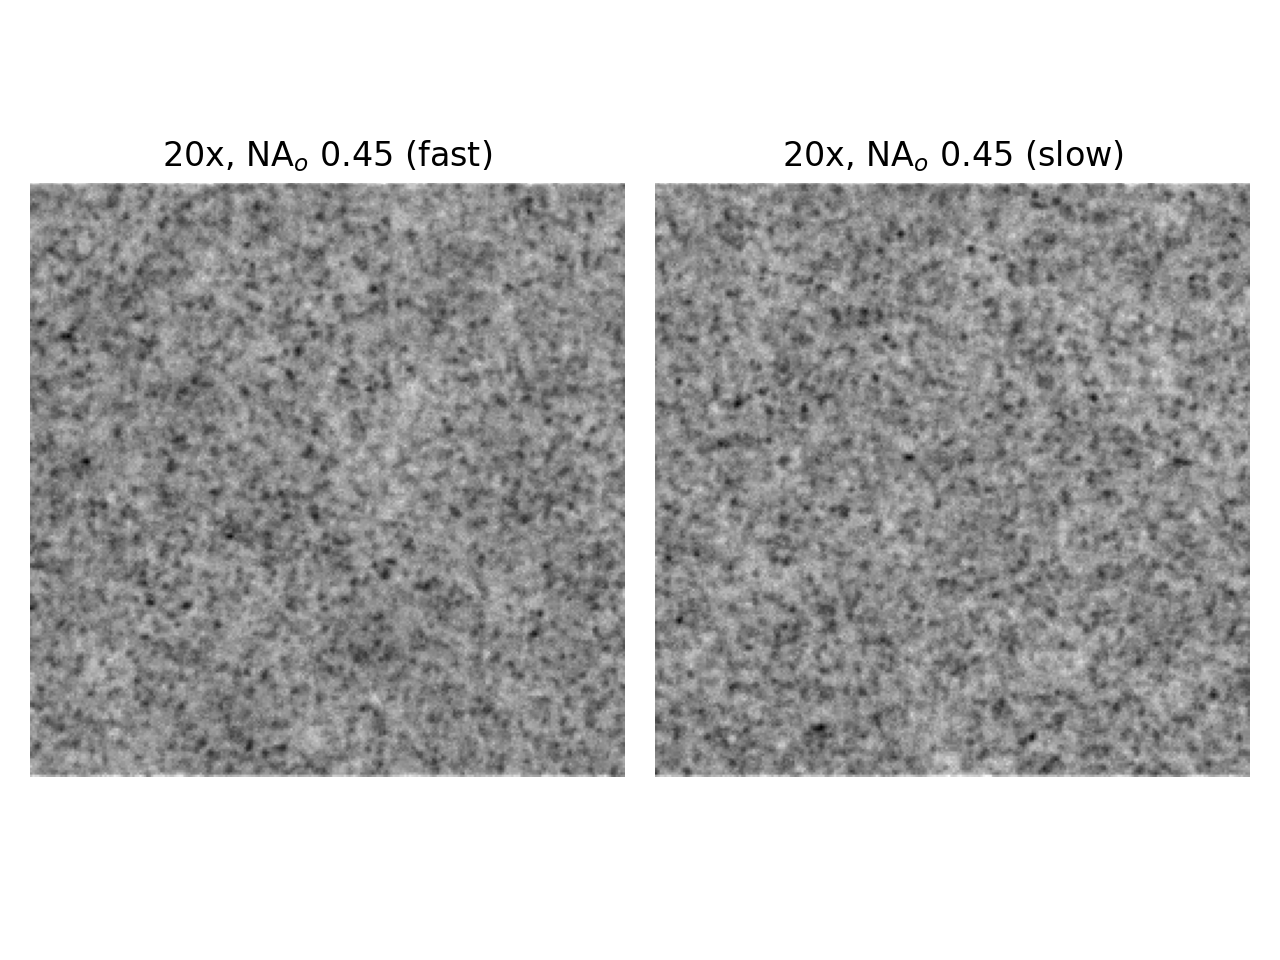

In [3]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=2)
axs = gs.subplots()

# read the images
images = [
    fd.read_images(file_path_fast, seq=[0])[0],
    fd.read_images(file_path_slow, seq=[0])[0],
]
images = np.array(images)

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

### 1.B-C. Structure function and azimuthal average calculation

The process here mirrors the one outlined in [tutorial1](../Tutorial_1-Particle_sizing/tutorial1.ipynb).
Use the following cell to select the `core` and `mode` you wish to use for the calculation of the structure function.

In [4]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
CORE = 'py'
#CORE = 'cpp'
#CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

Here, we set the experimental parameters of the acquisition.

In [5]:
# experimental acquisition parameters
magnification = 20
pixel_size = 6.5 / magnification  # microns per pixel

frame_rate_fast = 108    # frames per second
frame_rate_slow = 1      # frames per second

Finally, we separately compute the structure function and the azimuthal averages for the two acquisitions.

In [6]:
print('--- Calculating structure functions and azimuthal averages... ---')

# analyze fast acquisition
# notify user on progress
print(f'Analyzing fast movie ...')
    
# read image sequence
img_seq = fd.read_images(file_path_fast)
    
# compute structure function
# we analyze delays only up to half the length of the video
lags = range(1, int(len(img_seq) / 2))
dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
# set pixel size and time delay
dqt.pixel_size = pixel_size
dqt.set_frame_rate(frame_rate_fast)
    
# compute azimuthal average
bins = int(len(dqt.ky) / 2)                       # number of bins
bin_range = (0, dqt.ky[-1])                       # bin range
ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
# delete unused variables
del img_seq, dqt
gc.collect()
    
# analyze slow acquisition
# notify user on progress
print(f'Analyzing slow movie ...')
    
# read image sequence
img_seq = fd.read_images(file_path_slow)
    
# compute structure function
# we analyze delays only up to half the length of the video
lags = range(1, int(len(img_seq) / 2))
dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
# set pixel size and time delay
dqt.pixel_size = pixel_size
dqt.set_frame_rate(frame_rate_slow)
    
# compute azimuthal average
bins = int(len(dqt.ky) / 2)                       # number of bins
bin_range = (0, dqt.ky[-1])                       # bin range
ccm = fd.mask.central_cross_mask(dqt.shape[1:])   # mask for central cross
    
aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range, mask=ccm)
    
# delete unused variables
del img_seq, dqt
gc.collect();

--- Calculating structure functions and azimuthal averages... ---
Analyzing fast movie ...
Analyzing slow movie ...


## 2. Join (melt) fast and slow acquisitions

The strategy we use to melt different acquisitions is, roughly:
* select the first 10 points of the slow acquisition
* vertically shift these values by a multiplication factor to minimize the squared distance from the data of the fast acquisition in the same $\Delta t$ range
* use the (inverse of the) same factor to scale the fast data onto the slow ones.

To do this, we can use the `fastddm.azimuthalaverage.melt()` function, as you see below.

In [7]:
# melt the azimuthal averages
aa_melt = fd.azimuthalaverage.melt(aa_fast, aa_slow)

Now, we compare the two acquisitions and the output from the melting operation.

<IPython.core.display.Javascript object>


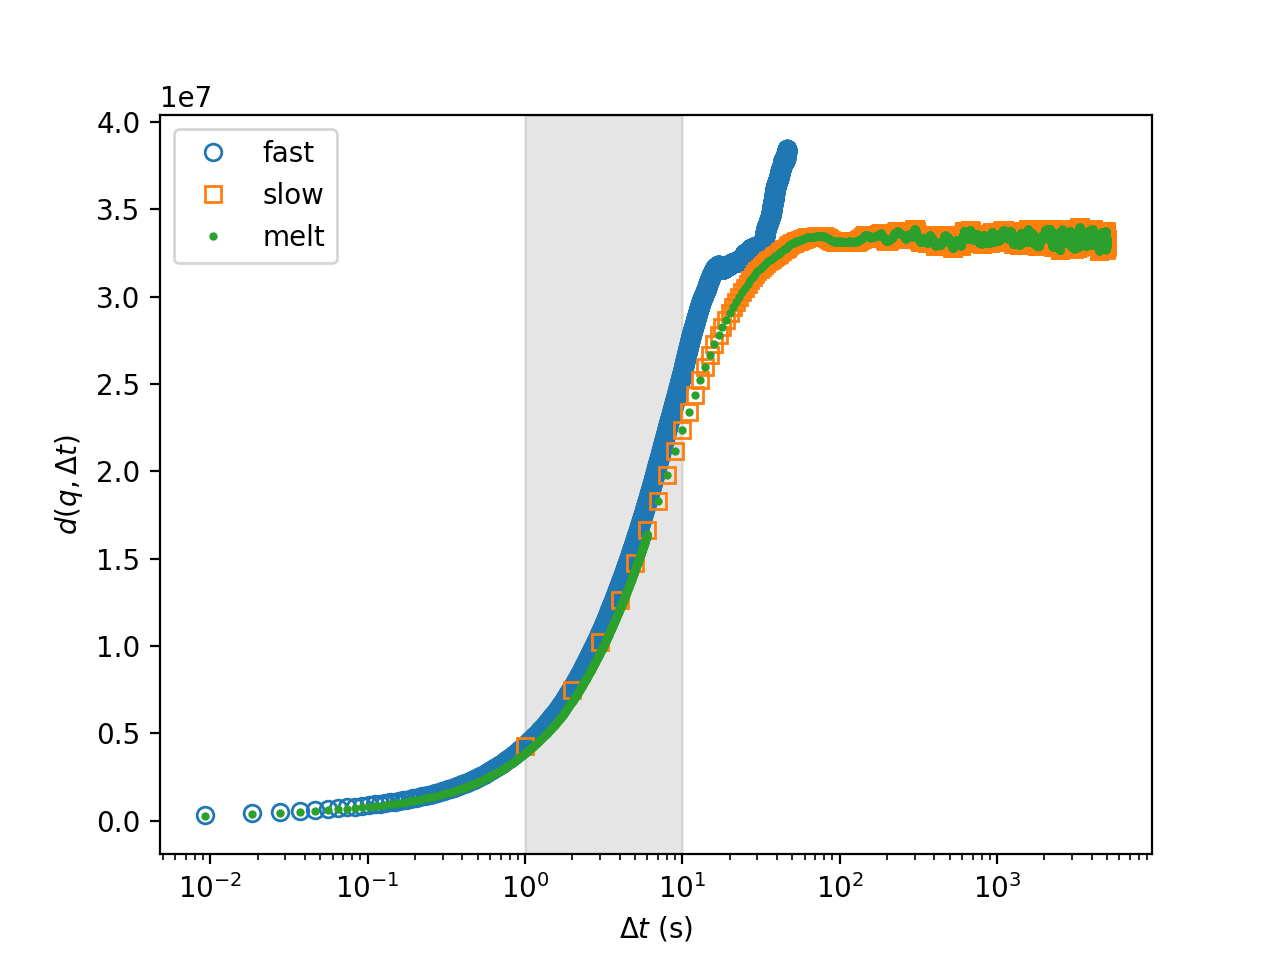

q = 0.339 1/μm


In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# select the wave vector index to plot and print its value
k_idx = 5
print(f'q = {aa_fast.k[k_idx]:.3f} 1/μm')

# show region where superposition is optimized
ax.fill_between(aa_slow.tau, 0, 1,
                where=aa_slow.tau <= aa_slow.tau[9],
                transform=ax.get_xaxis_transform(),
                color='gray', alpha=0.2)

# plot azimuthal average from fast acquisition
ax.plot(aa_fast.tau, aa_fast.data[k_idx], 'o', markerfacecolor='none',
        label='fast')

# plot azimuthal average from slow acquisition
ax.plot(aa_slow.tau, aa_slow.data[k_idx], 's', markerfacecolor='none',
        label='slow')

# plot melt
ax.plot(aa_melt.tau, aa_melt.data[k_idx], 'o', markersize=2, label='melt')

ax.set_xscale('log')
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'$d(q, \Delta t)$')
ax.legend();

As you see, the melt curve joins the scaled fast acquisition points with the slow data, providing a smooth curve on the whole range of lag times.

# (\*) Figures for paper

This last section is not part of the tutorial. If you are interested in getting the images used for the particle sizing section of our publication, feel free to set the following flag to `True` and run the cells below. You will need the `scienceplots` package, which is not among the ones required for these tutorials. You can install it through `pip`.

In [9]:
save_figures = False

In [10]:
if save_figures:
    # --- imports ---
    import scienceplots

    plt.style.use(['science', 'nature', 'vibrant'])
    mpl.rcParams['lines.markeredgewidth'] = 0.7
    
    # create FIGS directory
    os.makedirs('FIGS', exist_ok=True)

### Export images

In [11]:
if save_figures:
    # --- save comparison fast, slow, melt d(q,dt) ---
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    # select wave vector for plot
    k_idx = 5
    
    # show region where superposition is optimized
    ax.fill_between(aa_slow.tau, 0, 1,
                    where=aa_slow.tau <= aa_slow.tau[9],
                    transform=ax.get_xaxis_transform(),
                    color='gray', alpha=0.2)
    
    # plot fast, slow, and melt azimuthal averages
    ax.plot(aa_fast.tau, aa_fast.data[k_idx], 'o', markerfacecolor='none',
            label='fast', rasterized=True)
    ax.plot(aa_slow.tau, aa_slow.data[k_idx], 's', markerfacecolor='none',
            label='slow', rasterized=True)
    ax.plot(aa_melt.tau, aa_melt.data[k_idx], 'o', markersize=1,
            label='melt', rasterized=True)
    ax.set_xscale('log')
    ax.set_ylim(ymin=0)
    ax.set_xlabel(r'$\Delta t$ (s)')
    ax.set_ylabel(r'$d(q, \Delta t)$')
    ax.legend()
    
    fig.tight_layout()
    
    fig.savefig('FIGS/dqt_fast_slow_melt.pdf', dpi=600);